In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize': (9, 6)})

In [2]:
users_data = pd.read_csv('users_data.csv', index_col=0)

In [3]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


In [4]:
users_data[users_data.passed_course].day.median()

20.0

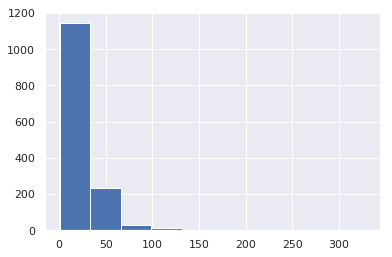

In [5]:
users_data[users_data.passed_course].day.hist()

In [6]:
events_data = pd.read_csv('event_data_train.csv')

In [7]:
events_data["date"] = pd.to_datetime(events_data.timestamp, unit='s')
events_data["day"] = events_data.date.dt.date

In [8]:
events_data.to_csv('events_data.csv')

In [9]:
user_min_time = events_data.groupby('user_id', as_index=False).agg({'timestamp': 'min'}).rename({'timestamp': 'min_timestamp'}, axis=1)

In [10]:
user_min_time.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


In [11]:
users_data = users_data.merge(user_min_time, how='outer')

In [12]:
events_data['user_time'] = events_data.user_id.map(str) + '_' + events_data.timestamp.map(str)

In [13]:
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895


In [14]:
learning_time_threshold = 3 * 24 * 60 * 60

In [15]:
learning_time_threshold

259200

In [16]:
user_learning_time_threshold = user_min_time.user_id.map(str) + '_' + (user_min_time.min_timestamp + learning_time_threshold).map(str)

In [17]:
user_learning_time_threshold.head()

0    1_1473086664
1    2_1514642564
2    3_1434617676
3    5_1466416009
4    7_1521893860
dtype: object

In [18]:
user_min_time['user_learning_time_threshold'] = user_learning_time_threshold

In [19]:
events_data = events_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')

In [20]:
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


In [22]:
events_data_train = events_data[events_data.user_time <= events_data.user_learning_time_threshold]


In [23]:
events_data_train.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


In [24]:
submissions_data = pd.read_csv('submissions_data_train.csv')

In [25]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [26]:
wrong_submissions_count = submissions_data[submissions_data.submission_status == 'wrong'].groupby('step_id').agg({'submission_status': 'count'})

In [71]:
wrong_submissions_count[wrong_submissions_count.submission_status == wrong_submissions_count.submission_status.max()]

,submission_status
step_id,
31978,16084


In [77]:
user_last_timestamp = submissions_data.groupby('user_id').agg({'timestamp': 'max'})

In [86]:
user_last_timestamp_with_steps = submissions_data.merge(user_last_timestamp)

In [87]:
user_last_timestamp_with_steps = user_last_timestamp_with_steps[user_last_timestamp_with_steps.submission_status =='wrong']

In [88]:
user_last_timestamp_with_steps = user_last_timestamp_with_steps.groupby('step_id').agg({'user_id': 'count'})

In [89]:
user_last_timestamp_with_steps[user_last_timestamp_with_steps.user_id == user_last_timestamp_with_steps.user_id.max()]

,user_id
step_id,
31978,156


In [27]:
events_data_train.groupby('user_id').day.nunique().max()

4

In [28]:
submissions_data["date"] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data["day"] = submissions_data.date.dt.date
submissions_data['user_time'] = submissions_data.user_id.map(str) + '_' + submissions_data.timestamp.map(str)
submissions_data = submissions_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')
submissions_data_train = submissions_data[submissions_data.user_time <= submissions_data.user_learning_time_threshold]
submissions_data_train.groupby('user_id').day.nunique().max()

4

In [29]:
X = submissions_data_train.groupby('user_id').day.nunique().to_frame().reset_index().rename(columns={'day': 'unique_days'})

In [30]:
X.head()

,user_id,unique_days
0,2,1
1,3,1
2,8,1
3,14,1
4,16,3


In [32]:
steps_tried = submissions_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index().rename(columns={'step_id': 'steps_tried'})

In [33]:
X = X.merge(steps_tried, on='user_id', how='outer')

In [34]:
X.shape

(8913, 3)

In [35]:
X = X.merge(submissions_data.pivot_table(index='user_id', 
                       columns='submission_status', 
                       values='step_id', 
                       aggfunc='count', 
                       fill_value=0).reset_index())

In [36]:
X['correct_ratio'] = X.correct / (X.correct + X.wrong)

In [37]:
X.head()

,user_id,unique_days,steps_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.000000
1,3,1,4,29,23,0.557692
2,8,1,11,9,21,0.300000
3,14,1,1,0,1,0.000000
4,16,3,23,77,106,0.420765


In [38]:
X = X.merge(events_data_train.pivot_table(index='user_id', 
                       columns='action', 
                       values='step_id', 
                       aggfunc='count', 
                       fill_value=0).reset_index()[['user_id', 'viewed']], how='outer')

In [39]:
X.user_id.nunique()

19234

In [40]:
X = X.fillna(0)

In [41]:
X = X.merge(users_data[['user_id', 'passed_course', 'is_gone_user']], how='outer')

In [42]:
X = X[~((X.is_gone_user == False) & (X.passed_course == False))]

In [43]:
X.head()

,user_id,unique_days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.000000,9,False,True
1,3,1.0,4.0,29.0,23.0,0.557692,20,False,True
2,8,1.0,11.0,9.0,21.0,0.300000,154,False,True
3,14,1.0,1.0,0.0,1.0,0.000000,9,False,True
4,16,3.0,23.0,77.0,106.0,0.420765,132,True,True


In [44]:
X.groupby(['passed_course', 'is_gone_user']).user_id.count()

passed_course  is_gone_user
False          True            16560
True           False             141
               True             1284
Name: user_id, dtype: int64

In [45]:
y = X.passed_course

In [46]:
X = X.drop(['passed_course', 'is_gone_user'], axis=1)

In [47]:
X = X.set_index(X.user_id)
X = X.drop('user_id', axis=1)

In [48]:
X.head()

,unique_days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.000000,9
3,1.0,4.0,29.0,23.0,0.557692,20
8,1.0,11.0,9.0,21.0,0.300000,154
14,1.0,1.0,0.0,1.0,0.000000,9
16,3.0,23.0,77.0,106.0,0.420765,132


In [49]:
y = y.map(int)

In [50]:
y.head()

0    0
1    0
2    0
3    0
4    1
Name: passed_course, dtype: int64

In [51]:
X.head()

,unique_days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.000000,9
3,1.0,4.0,29.0,23.0,0.557692,20
8,1.0,11.0,9.0,21.0,0.300000,154
14,1.0,1.0,0.0,1.0,0.000000,9
16,3.0,23.0,77.0,106.0,0.420765,132


In [52]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

In [53]:
clf = DecisionTreeClassifier()

In [55]:
df = RandomizedSearchCV(clf, {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 20),
    'min_samples_split': range(2, 20),
    'min_samples_leaf': range(1, 20)
}, cv=5)

In [56]:
df.fit(X, y)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'criterion': ['gini', 'entropy'], 'max_depth': range(1, 20), 'min_samples_split': range(2, 20), 'min_samples_leaf': range(1, 20)},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [57]:
df.best_params_

{'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 1,
 'criterion': 'gini'}

In [61]:
from sklearn import tree
from IPython.display import SVG, display
from graphviz import Source
from IPython.display import HTML
style = "<style>svg{width:70%!important;height:70%!important;}</style>"
HTML(style)

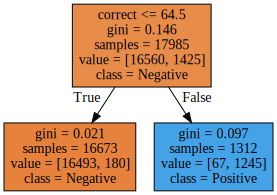

In [62]:
graph = Source(tree.export_graphviz(df.best_estimator_, out_file=None,
                                   feature_names=list(X),
                                   class_names=['Negative','Positive'],
                                   filled = True))

display(SVG(graph.pipe(format='svg')))

In [73]:
from sklearn.metrics import precision_score, recall_score

In [64]:
from sklearn.model_selection import train_test_split

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [66]:
clf = DecisionTreeClassifier()
df = RandomizedSearchCV(clf, {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 20),
    'min_samples_split': range(2, 20),
    'min_samples_leaf': range(1, 20)
}, cv=5)
df.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'criterion': ['gini', 'entropy'], 'max_depth': range(1, 20), 'min_samples_split': range(2, 20), 'min_samples_leaf': range(1, 20)},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [67]:
best_clf = df.best_estimator_

In [86]:
df.best_params_

{'min_samples_split': 9,
 'min_samples_leaf': 18,
 'max_depth': 6,
 'criterion': 'gini'}

In [69]:
predictions = best_clf.predict(X_test)

In [74]:
precision = precision_score(y_test, predictions, average='macro')

In [75]:
precision

0.9560891428768694

In [72]:
best_clf.score(X_test, y_test)

0.9824327329330665

In [76]:
recall = recall_score(y_test, predictions)

In [78]:
y_pred_prob = best_clf.predict_proba(X_test)

In [80]:
y_pred_prob

array([[1.        , 0.        ],
       [0.00943396, 0.99056604],
       [1.        , 0.        ],
       ...,
       [0.98998045, 0.01001955],
       [1.        , 0.        ],
       [1.        , 0.        ]])

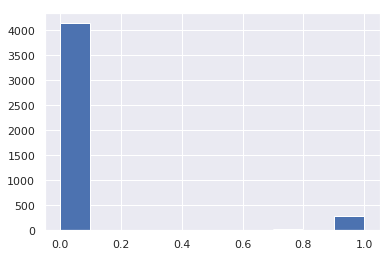

In [79]:
pd.Series(y_pred_prob[:, 1]).hist()

In [83]:
pd.Series(y_pred_prob[:, 1]).unique()

array([0.        , 0.99056604, 0.01725888, 0.01001955, 1.        ,
       0.02702703, 0.96202532, 0.45454545, 0.012     , 0.96666667,
       0.06711409, 0.96969697, 0.05      , 0.52631579, 0.94444444,
       0.76923077, 0.17857143, 0.71428571, 0.88461538, 0.05555556,
       0.11111111, 0.79166667])

In [77]:
recall

0.8512396694214877

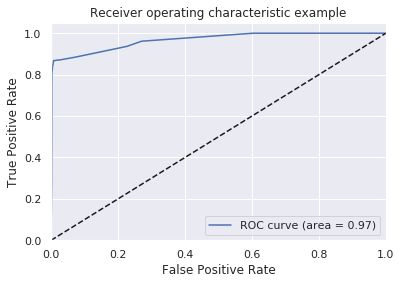

In [84]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

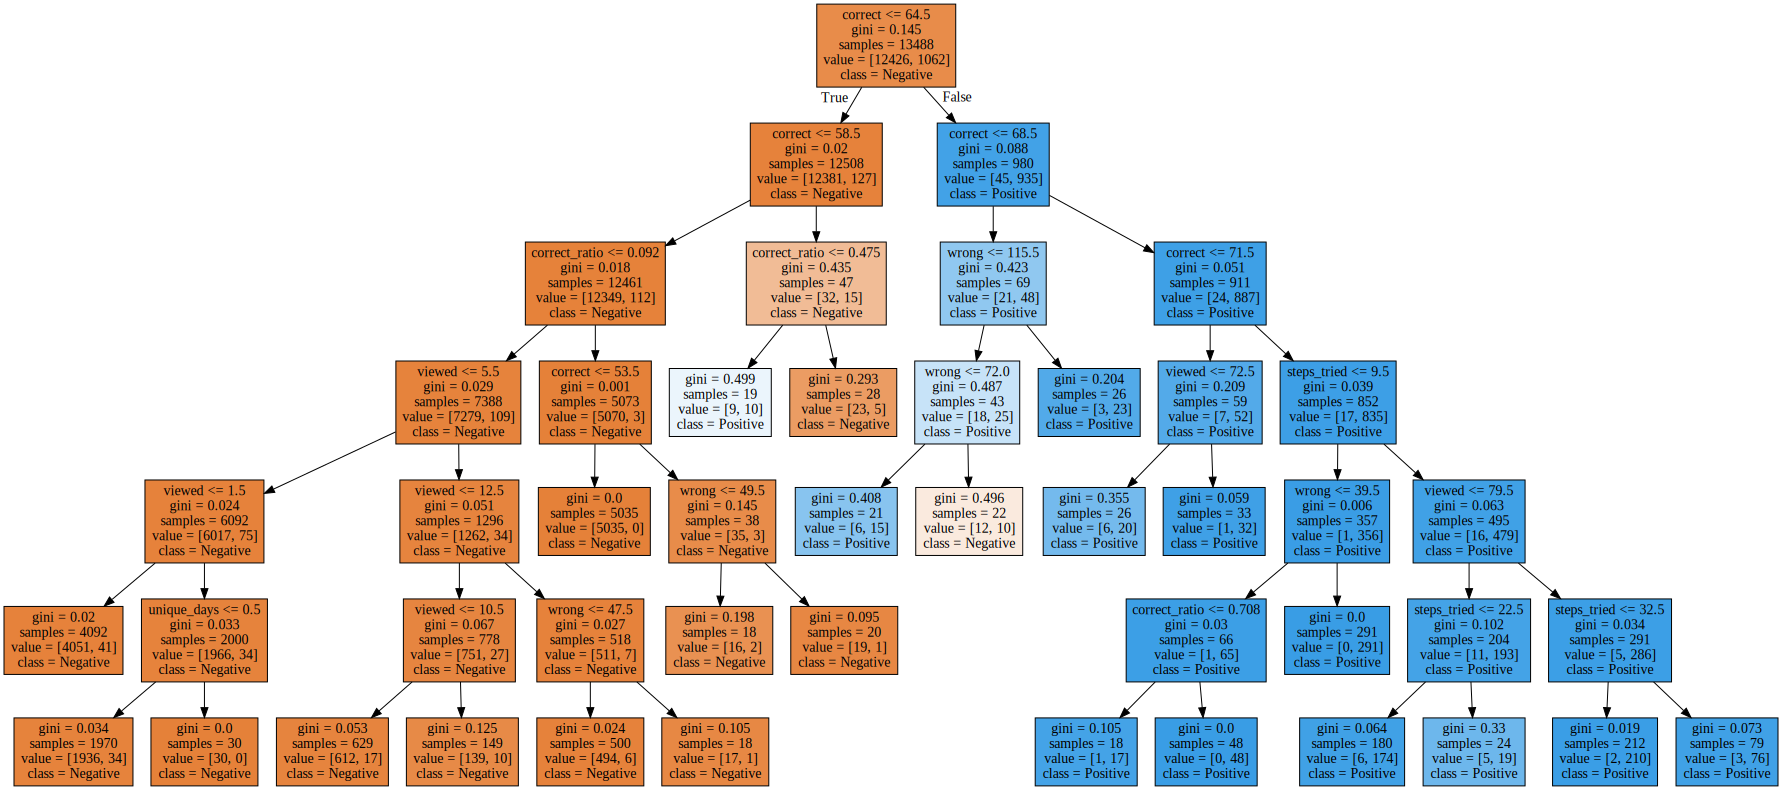

In [85]:
graph = Source(tree.export_graphviz(best_clf, out_file=None,
                                   feature_names=list(X),
                                   class_names=['Negative','Positive'],
                                   filled = True))

display(SVG(graph.pipe(format='svg')))